In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform

from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading data

In [12]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv")
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv")
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv")
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv")

In [13]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

### Establishing baseline brier score for default hyperparameters

In [14]:
RANDOM_STATE = 42
model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
model.fit(X1_train, y1_train)
y_proba = model.predict_proba(X1_test)[:, 1]
brier1 = brier_score_loss(y1_test, y_proba)
model.fit(X2_train, y2_train)
y2_proba = model.predict_proba(X2_test)[:, 1]
brier2 = brier_score_loss(y2_test, y2_proba)
model.fit(X3_train, y3_train)
y3_proba = model.predict_proba(X3_test)[:, 1]
brier3 = brier_score_loss(y3_test, y3_proba)
model.fit(X4_train, y4_train)
y4_proba = model.predict_proba(X4_test)[:, 1]
brier4 = brier_score_loss(y4_test, y4_proba)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Nie można odnaleźć określonego pliku
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of c

[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 8929, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473849 -> initscore=-0.104699
[LightGBM] [Info] Start training from score -0.104699
[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 1583, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.401137 -> initscore=-0.400730
[LightGBM] 

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [15]:
print(brier1)
print(brier2)
print(brier3)
print(brier4)

0.1835232471728478
0.2018081787955161
0.0982194936261805
0.178996854771902


### Random search optimization
https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-hyperparameters.html
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html?utm_source=chatgpt.com

In [55]:
param_grid = {
    'num_leaves': randint(15, 128),
    'max_depth': randint(3, 15),  
    'learning_rate': loguniform(0.01, 0.3),
    'n_estimators': randint(100, 1500),
    'min_data_in_leaf': randint(10, 200),
    'lambda_l1': loguniform(1e-4, 10),  
    'lambda_l2': loguniform(1e-4, 10)
}

In [56]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10           
TOL = 0.001 
CV = 5

In [57]:
iters = np.arange(1, N_ITER + 1)

In [58]:
model = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs = 1)

In [59]:
rnd = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=N_ITER,
    scoring=SCORER,
    verbose=0,
    cv=CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True
)

#### Bank data

In [60]:
rnd.fit(X1_train, y1_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003659 seconds.
You can set `force_col_wi

,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001F7A4E7E120>, 'lambda_l2': <scipy.stats....001F7A4E7F890>, 'learning_rate': <scipy.stats....001F7A4F84A50>, 'max_depth': <scipy.stats....001F7A83AB930>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [61]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [62]:
rnd.best_params_

{'lambda_l1': np.float64(0.0010799951355893044),
 'lambda_l2': np.float64(0.0023431799179763242),
 'learning_rate': np.float64(0.020747900173109644),
 'max_depth': 4,
 'min_data_in_leaf': 44,
 'n_estimators': 826,
 'num_leaves': 95}

In [63]:
best_so_far[-1]

np.float64(0.18386437309700304)

### Criterium of stabilization - in 10 steps in a row there is no improvement in brier score more than 1e-3

In [64]:
WINDOW_SIZE = 10 
ABS_TOL = 0.001   

In [65]:
def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len = WINDOW_SIZE):
    """
    Szuka pierwszego okna długości 10 takie, że wszystkie 9 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window)) 
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None

In [66]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [67]:
print(stabilized_at, stabilized_value)

2 0.1856140031909646


In [73]:
def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, default):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title('Brier per Random Search iteration and best-so-far')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

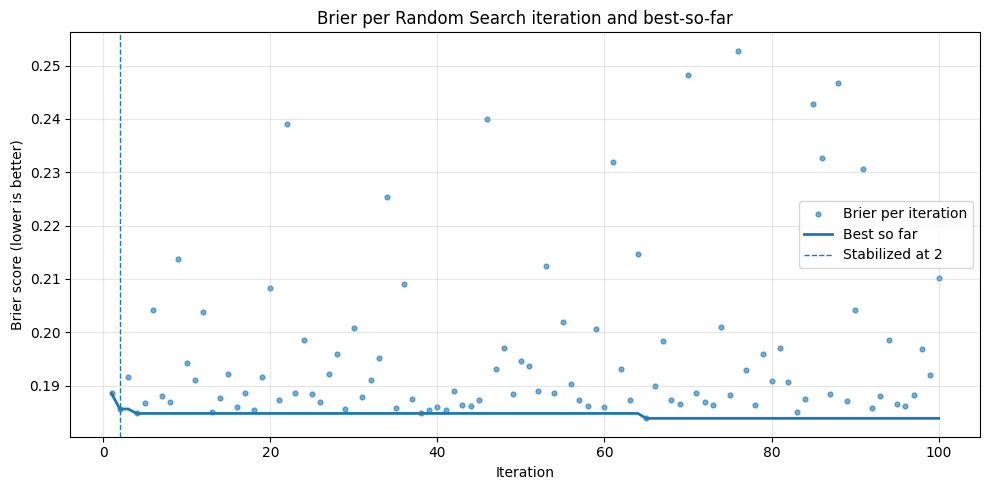

In [74]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier1)

##### Benchmark on test data with those hyperparams

In [70]:
best_params = rnd.best_params_
model = lgb.LGBMClassifier(**best_params)
model.fit(X1_train, y1_train)
y_proba = model.predict_proba(X1_test)[:, 1]
brier_adjusted1 = brier_score_loss(y1_test, y_proba)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wi

In [71]:
print(brier_adjusted1, brier1)

0.18111966687301606 0.1835232471728478


#### Gym data

In [72]:
rnd.fit(X2_train, y2_train)

[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001F7A4E7E120>, 'lambda_l2': <scipy.stats....001F7A4E7F890>, 'learning_rate': <scipy.stats....001F7A4F84A50>, 'max_depth': <scipy.stats....001F7A83AB930>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [75]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [76]:
rnd.best_params_

{'lambda_l1': np.float64(0.00922459366331435),
 'lambda_l2': np.float64(1.399010917215618),
 'learning_rate': np.float64(0.06927911541220201),
 'max_depth': 3,
 'min_data_in_leaf': 107,
 'n_estimators': 204,
 'num_leaves': 113}

In [77]:
best_so_far[-1]

np.float64(0.14684339342706773)

In [78]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [79]:
print(stabilized_at, stabilized_value)

7 0.1489718188992759


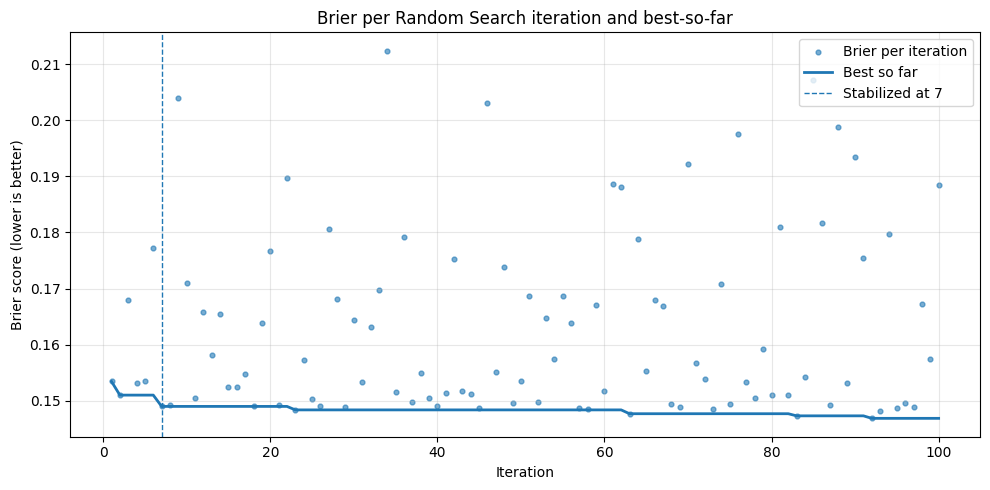

In [80]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier2)

In [81]:
best_params = rnd.best_params_
model = lgb.LGBMClassifier(**best_params)
model.fit(X2_train, y2_train)
y_proba = model.predict_proba(X2_test)[:, 1]
brier_adjusted2 = brier_score_loss(y2_test, y_proba)

[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [82]:
print(brier_adjusted2, brier2)

0.17634326427209 0.2018081787955161


#### Heart disease data

In [83]:
rnd.fit(X3_train, y3_train)

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001F7A4E7E120>, 'lambda_l2': <scipy.stats....001F7A4E7F890>, 'learning_rate': <scipy.stats....001F7A4F84A50>, 'max_depth': <scipy.stats....001F7A83AB930>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [84]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [85]:
rnd.best_params_

{'lambda_l1': np.float64(0.024046589187280348),
 'lambda_l2': np.float64(1.435018335977515),
 'learning_rate': np.float64(0.02848552988592319),
 'max_depth': 3,
 'min_data_in_leaf': 63,
 'n_estimators': 335,
 'num_leaves': 19}

In [86]:
best_so_far[-1]

np.float64(0.1230000359906959)

In [87]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [88]:
print(stabilized_at, stabilized_value)

3 0.12410485810542722


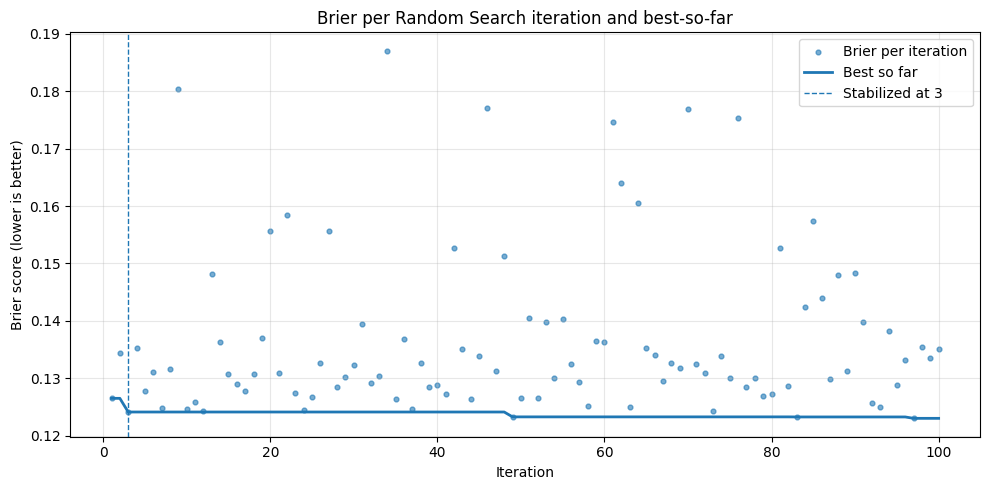

In [89]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier3)

In [90]:
best_params = rnd.best_params_
model = lgb.LGBMClassifier(**best_params)
model.fit(X3_train, y3_train)
y_proba = model.predict_proba(X3_test)[:, 1]
brier_adjusted3 = brier_score_loss(y3_test, y_proba)

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [91]:
print(brier_adjusted3, brier3)

0.09262259701874374 0.0982194936261805


#### Titanic data

In [92]:
rnd.fit(X4_train, y4_train)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Info] Number of positive: 271, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001F7A4E7E120>, 'lambda_l2': <scipy.stats....001F7A4E7F890>, 'learning_rate': <scipy.stats....001F7A4F84A50>, 'max_depth': <scipy.stats....001F7A83AB930>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [93]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [94]:
rnd.best_params_

{'lambda_l1': np.float64(1.3783040076490758),
 'lambda_l2': np.float64(0.002278843910062451),
 'learning_rate': np.float64(0.2665593954919876),
 'max_depth': 9,
 'min_data_in_leaf': 15,
 'n_estimators': 976,
 'num_leaves': 110}

In [95]:
best_so_far[-1]

np.float64(0.1068854416989623)

In [96]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [97]:
print(stabilized_at, stabilized_value)

4 0.11104287081018767


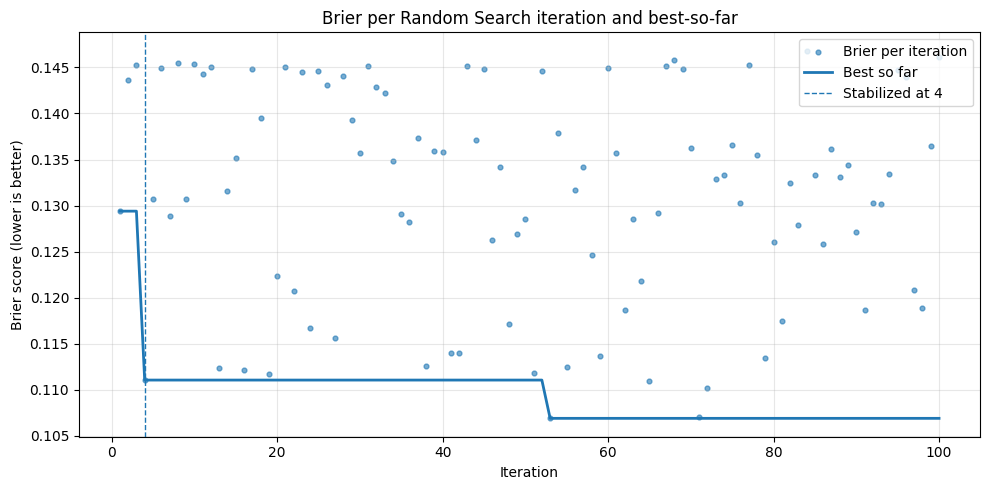

In [98]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier4)

In [99]:
best_params = rnd.best_params_
model = lgb.LGBMClassifier(**best_params)
model.fit(X4_train, y4_train)
y_proba = model.predict_proba(X4_test)[:, 1]
brier_adjusted4 = brier_score_loss(y4_test, y_proba)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Info] Number of positive: 271, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [100]:
print(brier_adjusted4, brier4)

0.15942538000177728 0.178996854771902
